In [1]:
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical
from nltk.tokenize import RegexpTokenizer
import pandas as pd
import string
import numpy as np
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.model_selection import train_test_split, GridSearchCV
plt.rcParams['font.size'] = 24

Using TensorFlow backend.


In [2]:
df = pd.read_csv('../data/WEEK_2_DESCRIPTIONS.csv').drop('Unnamed: 0', axis=1)

In [3]:
def bin_scores(score):
    if score > 60:
        if score > 75:
            return 2
        return 1
    return 0

df['success'] = df['Critic_Score'].apply(bin_scores)

def clean_text(text):
    
    # Removes punctuation
    words = [''.join(ch for ch in s if ch not in string.punctuation)\
             for s in text.split()]
    
    # Returns the lower-case string
    return ' '.join(words).lower()

df.plots = df.plots.apply(clean_text)

In [4]:
tokenizer = RegexpTokenizer(r'\w+')
df['tokens'] = df.plots.apply(tokenizer.tokenize)

In [6]:
cv = CountVectorizer()
X_train, X_test, y_train, y_test = train_test_split(df.plots, df.success, random_state=1)
X_train_counts = cv.fit_transform(X_train)
X_test_counts = cv.transform(X_test)


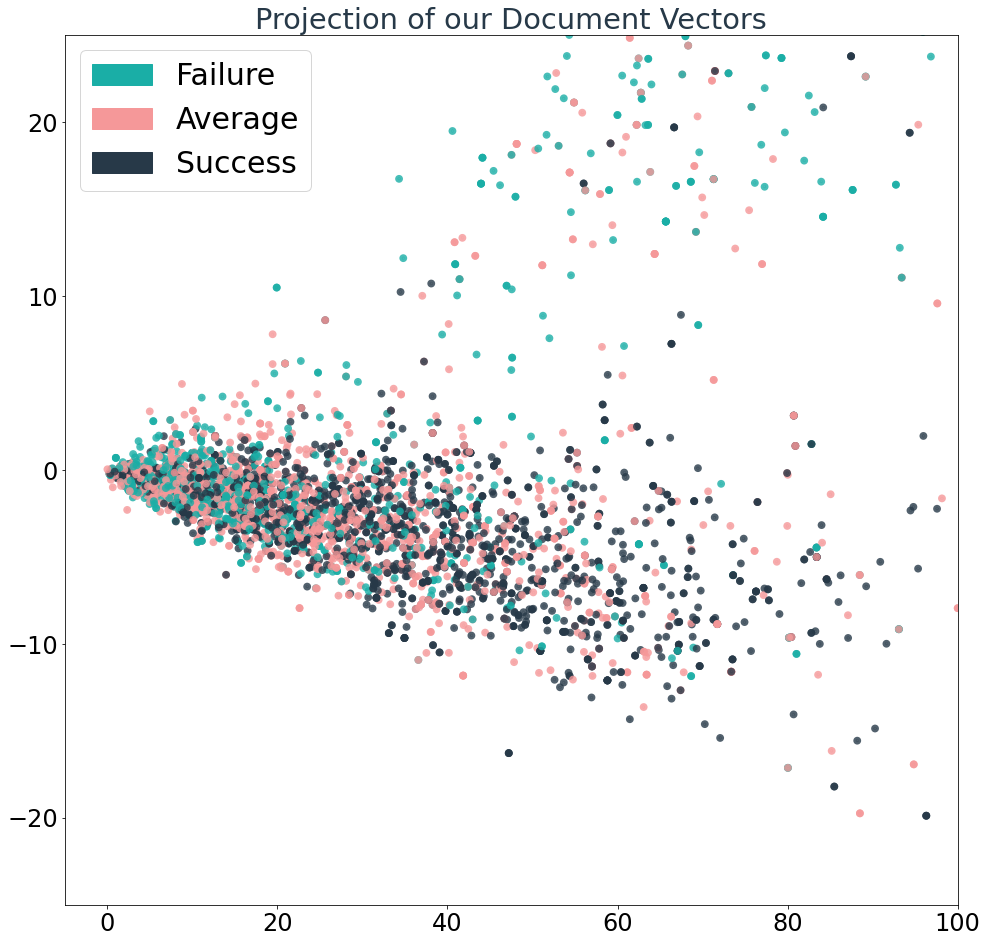

In [7]:
from sklearn.decomposition import PCA, TruncatedSVD
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import matplotlib


def plot_LSA(test_data, test_labels, savepath="../reports/figures/PCA_demo.csv", plot=True):
        lsa = TruncatedSVD(n_components=2)
        lsa.fit(test_data)
        lsa_scores = lsa.transform(test_data)
        color_mapper = {label:idx for idx,label in enumerate(set(test_labels))}
        color_column = [color_mapper[label] for label in test_labels]
        colors = ['#1AAEA6','#F59899','#273948']
        if plot:
            plt.scatter(lsa_scores[:,0], lsa_scores[:,1], s=8, alpha=.8, c=test_labels, cmap=matplotlib.colors.ListedColormap(colors),
                       linewidth=5)
            plt.rc_context({'axes.edgecolor':'#273948', 'xtick.color':'#273948', 'ytick.color':'#273948', 'figure.facecolor':'white'})

            red_patch = mpatches.Patch(color='#1AAEA6', label='Failure')
            green_patch = mpatches.Patch(color='#F59899', label='Average')
            third_patch = mpatches.Patch(color='#273948', label='Success')
            plt.legend(handles=[red_patch, green_patch,third_patch], prop={'size': 30})


fig = plt.figure(figsize=(16, 16))          
plot_LSA(X_train_counts, y_train)
plt.rc_context({'axes.edgecolor':'#273948', 'xtick.color':'#273948', 'ytick.color':'#273948', 'figure.facecolor':'white'})
plt.ylim((-25,25))
plt.xlim((-5,100))
plt.grid(False)
plt.title('Projection of our Document Vectors', color='#273948')
plt.savefig('../src/figures/dimensionality.png')
plt.show()

In [8]:
from sklearn.linear_model import LogisticRegression

clf = LogisticRegression(C=30.0, class_weight='balanced', solver='newton-cg', 
                         multi_class='multinomial', n_jobs=-1, random_state=40)
clf.fit(X_train_counts, y_train)

y_predicted_counts = clf.predict(X_test_counts)

In [9]:

from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, classification_report

def get_metrics(y_test, y_predicted):  
    # true positives / (true positives+false positives)
    precision = precision_score(y_test, y_predicted, pos_label=None,
                                    average='weighted')             
    # true positives / (true positives + false negatives)
    recall = recall_score(y_test, y_predicted, pos_label=None,
                              average='weighted')
    
    # harmonic mean of precision and recall
    f1 = f1_score(y_test, y_predicted, pos_label=None, average='weighted')
    
    # true positives + true negatives/ total
    accuracy = accuracy_score(y_test, y_predicted)
    return accuracy, precision, recall, f1

accuracy, precision, recall, f1 = get_metrics(y_test, y_predicted_counts)
print("accuracy = %.3f, precision = %.3f, recall = %.3f, f1 = %.3f" % (accuracy, precision, recall, f1))

accuracy = 0.641, precision = 0.645, recall = 0.641, f1 = 0.643


In [10]:
tf = TfidfVectorizer(stop_words='english')
X_train_tfidf = tf.fit_transform(X_train)
X_test_tfidf = tf.transform(X_test)

In [11]:
clf_tfidf = LogisticRegression(C=30.0, class_weight='balanced', solver='newton-cg', 
                         multi_class='multinomial', n_jobs=-1, random_state=40)
clf_tfidf.fit(X_train_tfidf, y_train)

y_predicted_tfidf = clf_tfidf.predict(X_test_tfidf)

In [12]:

accuracy_tfidf, precision_tfidf, recall_tfidf, f1_tfidf = get_metrics(y_test, y_predicted_tfidf)
print("accuracy = %.3f, precision = %.3f, recall = %.3f, f1 = %.3f" % (accuracy_tfidf, precision_tfidf, 
                                                                       recall_tfidf, f1_tfidf))

accuracy = 0.653, precision = 0.652, recall = 0.653, f1 = 0.652


In [13]:
def get_most_important_features(vectorizer, model, n=5):
    index_to_word = {v:k for k,v in vectorizer.vocabulary_.items()}
    
    # loop for each class
    classes ={}
    for class_index in range(model.coef_.shape[0]):
        word_importances = [(el, index_to_word[i]) for i,el in enumerate(model.coef_[class_index])]
        sorted_coeff = sorted(word_importances, key = lambda x : x[0], reverse=True)
        tops = sorted(sorted_coeff[:n], key = lambda x : x[0])
        bottom = sorted_coeff[-n:]
        classes[class_index] = {
            'tops':tops,
            'bottom':bottom
        }
    return classes

importance = get_most_important_features(tf, clf_tfidf, 10)

In [14]:
importance
clf_tfidf.coef_

array([[ 0.28860162, -0.26612528,  0.36047215, ..., -0.17718076,
         0.15416224, -0.17718076],
       [-0.44777899,  0.47542078, -0.22796392, ..., -0.19105761,
        -0.09697327, -0.19105761],
       [ 0.15917737, -0.2092955 , -0.13250823, ...,  0.36823836,
        -0.05718898,  0.36823836]])

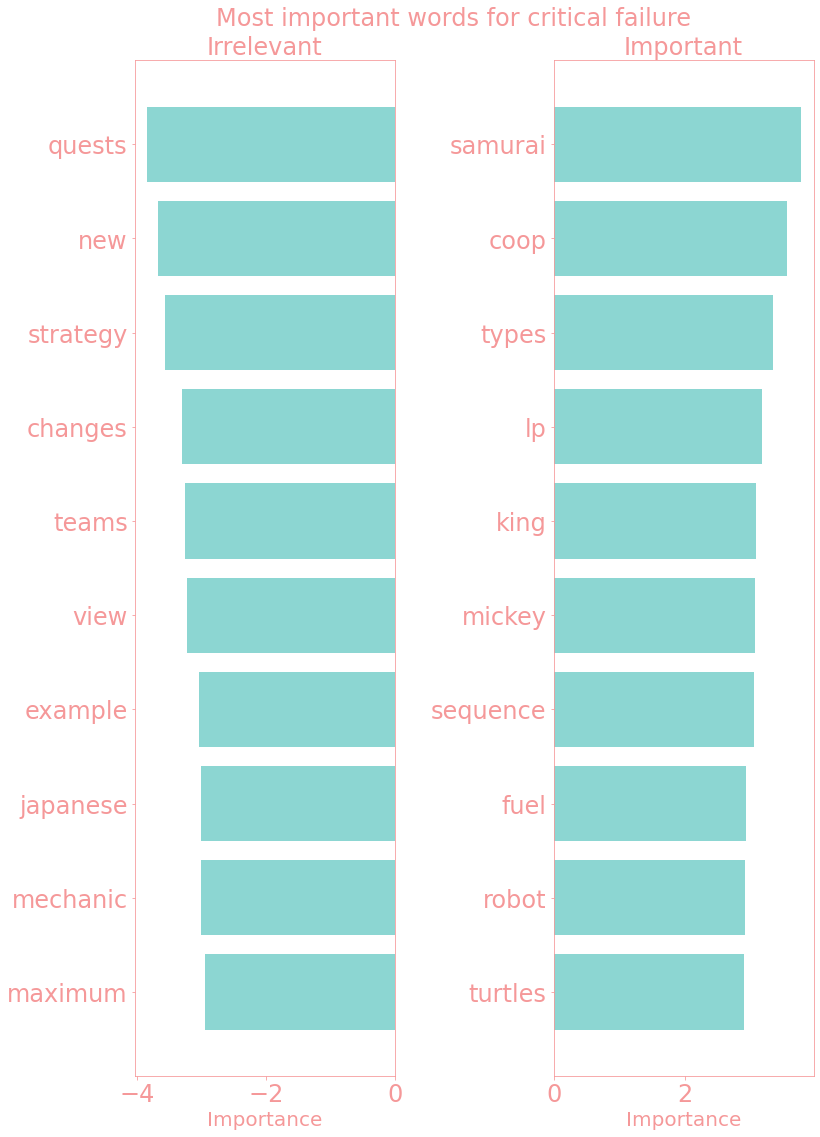

In [15]:
def plot_important_words(top_scores, top_words, bottom_scores, bottom_words, name):
    y_pos = np.arange(len(top_words))
    top_pairs = [(a,b) for a,b in zip(top_words, top_scores)]
    top_pairs = sorted(top_pairs, key=lambda x: x[1])
    
    bottom_pairs = [(a,b) for a,b in zip(bottom_words, bottom_scores)]
    bottom_pairs = sorted(bottom_pairs, key=lambda x: x[1], reverse=True)
    
    top_words = [a[0] for a in top_pairs]
    top_scores = [a[1] for a in top_pairs]
    
    bottom_words = [a[0] for a in bottom_pairs]
    bottom_scores = [a[1] for a in bottom_pairs]
    
    fig = plt.figure(figsize=(12,16))
    plt.rc_context({'axes.edgecolor':'#F59899', 'xtick.color':'#F59899', 'ytick.color':'#F59899', 'figure.facecolor':'white'})

    plt.subplot(121)
    plt.grid(False)
    plt.barh(y_pos,bottom_scores, align='center', alpha=0.5,  color='#1AAEA6')
    plt.title('Irrelevant', fontsize=24, color='#F59899')
    plt.yticks(y_pos, bottom_words, fontsize=24)
    plt.suptitle('Key words', fontsize=16, y=1.2)
    plt.xlabel('Importance', fontsize=20, color='#F59899')
    
    plt.subplot(122)
    plt.grid(False)
    plt.barh(y_pos,top_scores, align='center', alpha=0.5,  color='#1AAEA6')
    plt.title('Important', fontsize=24, color='#F59899')
    plt.yticks(y_pos, top_words, fontsize=24)
    plt.suptitle(name, fontsize=24, color='#F59899', y=1, x=.55)
    plt.xlabel('Importance', fontsize=20, color='#F59899')
    
    
    plt.subplots_adjust(wspace=0.8)
    plt.tight_layout(pad=1.2)
    plt.savefig('../src/figures/word_importances.png', transparent=True)
    plt.show()

top_scores = [a[0] for a in importance[0]['tops']]
top_words = [a[1] for a in importance[0]['tops']]
bottom_scores = [a[0] for a in importance[0]['bottom']]
bottom_words = [a[1] for a in importance[0]['bottom']]

plot_important_words(top_scores, top_words, bottom_scores, bottom_words, "Most important words for critical failure")

In [122]:
2 or 1

2

In [10]:
import gensim
import pickle
import bz2
import xgboost

In [11]:
word2vec_path = 'http://wikipedia2vec.s3.amazonaws.com/models/en/2018-04-20/enwiki_20180420_win10_500d.txt.bz2'
word2vec = gensim.models.KeyedVectors.load_word2vec_format(word2vec_path, limit=1000000)

In [12]:
len(word2vec['game'])

500

In [ ]:

def get_average_word2vec(tokens_list, vector, generate_missing=False, k=300):
    imputed = 0
    if len(tokens_list)<1:
        return np.zeros(k)
    if generate_missing:
        vectorized = [vector[word] if word in vector else np.random.rand(k) for word in tokens_list]
        
    else:
        vectorized = [vector[word] if word in vector else np.zeros(k) for word in tokens_list]
    print(sum(word not in vector for word in tokens_list))
    length = len(vectorized)
    summed = np.sum(vectorized, axis=0)
    averaged = np.divide(summed, length)
    return averaged

def get_word2vec_embeddings(vectors, clean_questions, generate_missing=False, k=300):
    embeddings = df['tokens'].apply(lambda x: get_average_word2vec(x, vectors, generate_missing=generate_missing, k=k))
    return list(embeddings)

In [81]:

embeddings = get_word2vec_embeddings(word2vec, df, True, 500)
X_train_word2vec, X_test_word2vec, y_train_word2vec, y_test_word2vec = train_test_split(embeddings, df.success, 
                                                                                        test_size=0.2, random_state=40)

5
4
1
3
2
9
3
1
22
15
13
8
15
12
2
25
1
6
10
1
12
4
5
6
15
4
10
22
11
2
11
10
11
2
4
9
4
10
1
5
1
7
7
18
8
9
0
12
6
4
11
4
2
4
1
4
9
1
4
18
1
18
10
11
4
16
10
3
6
7
1
7
0
12
25
7
12
18
4
8
9
12
3
0
13
4
9
5
13
17
2
11
0
1
7
4
22
2
18
3
6
6
19
15
0
3
8
1
11
25
4
2
18
5
5
14
12
10
12
2
3
7
10
6
8
12
8
4
9
3
9
17
3
5
2
22
7
19
4
30
10
11
15
5
4
18
10
4
13
10
6
0
3
16
8
4
10
10
8
6
18
17
8
18
6
8
11
15
11
5
6
2
5
0
8
7
20
3
17
7
15
16
3
7
3
9
12
18
38
15
2
3
11
0
4
9
22
4
7
9
9
17
4
4
13
5
2
12
5
7
4
6
2
11
7
10
14
0
5
18
5
3
5
9
19
7
2
14
10
1
16
5
8
11
9
4
30
8
9
30
5
17
9
8
0
5
7
3
5
7
9
5
5
8
12
5
4
2
2
16
15
9
6
4
9
11
1
3
10
11
20
4
5
13
10
9
5
4
16
20
17
11
10
5
3
4
11
7
1
14
2
4
0
9
8
9
5
10
14
9
6
5
4
8
2
6
14
22
8
7
4
10
9
6
13
14
13
15
12
8
5
4
10
9
0
1
9
10
8
8
32
3
1
22
3
8
14
10
9
0
9
0
2
20
3
26
0
12
9
8
22
1
9
11
9
7
8
6
10
2
3
14
10
0
14
8
11
27
3
4
0
9
11
10
3
2
4
3
38
4
5
2
7
7
25
22
16
3
8
4
23
8
5
2
9
5
17
12
13
6
4
3
1
6
8
6
8
0
10
10
7
8
10
6
3
4
3
4
5
9
3
3
5
11
1
9

In [71]:
len(embeddings[0])

500

In [72]:

clf_w2v = LogisticRegression(penalty='l2', C=100, class_weight='balanced',solver='saga', 
                         multi_class='multinomial', max_iter=1000)
clf_w2v.fit(X_train_word2vec, y_train_word2vec)
y_predicted_word2vec = clf_w2v.predict(X_test_word2vec)

In [73]:

accuracy_word2vec, precision_word2vec, recall_word2vec, f1_word2vec = get_metrics(y_test_word2vec, y_predicted_word2vec)
print("accuracy = %.3f, precision = %.3f, recall = %.3f, f1 = %.3f" % (accuracy_word2vec, precision_word2vec, 
                                                                       recall_word2vec, f1_word2vec))

accuracy = 0.536, precision = 0.542, recall = 0.536, f1 = 0.537


In [114]:
from sklearn.ensemble import RandomForestClassifier
rf_w2v = RandomForestClassifier(criterion='entropy')
rf_w2v.fit(X_train_word2vec, y_train_word2vec)
y_predicted_word2vec = rf_w2v.predict(X_test_word2vec)

In [115]:

accuracy_word2vec, precision_word2vec, recall_word2vec, f1_word2vec = get_metrics(y_test_word2vec, y_predicted_word2vec)
print("accuracy = %.3f, precision = %.3f, recall = %.3f, f1 = %.3f" % (accuracy_word2vec, precision_word2vec, 
                                                                       recall_word2vec, f1_word2vec))

accuracy = 0.640, precision = 0.649, recall = 0.640, f1 = 0.639


In [124]:
from xgboost import XGBClassifier

In [132]:
xg = XGBClassifier(max_depth = 8, n_estimators=1000)
xg.fit(np.array(X_train_word2vec), np.array(y_train_word2vec))

XGBClassifier(max_depth=8, n_estimators=1000, objective='multi:softprob')

In [133]:
y_predicted_word2vec = xg.predict(X_test_word2vec)

accuracy_word2vec, precision_word2vec, recall_word2vec, f1_word2vec = get_metrics(y_test_word2vec, y_predicted_word2vec)
print("accuracy = %.3f, precision = %.3f, recall = %.3f, f1 = %.3f" % (accuracy_word2vec, precision_word2vec, 
                                                                       recall_word2vec, f1_word2vec))

accuracy = 0.653, precision = 0.658, recall = 0.653, f1 = 0.652


In [136]:
# from gensim.scripts.glove2word2vec import glove2word2vec
# glove_input_file = 'http://nlp.stanford.edu/data/glove.42B.300d.zip'
# word2vec_output_file = 'glove.6B.100d.txt.word2vec'
# glove2word2vec(glove_input_file, word2vec_output_file)

In [ ]:
glove = gensim.models.KeyedVectors.load_word2vec_format(word2vec_path)

In [ ]:
embeddings = get_word2vec_embeddings(glove, df, True)
X_train_glove, X_test_glove, y_train_glove, y_test_glove = train_test_split(embeddings, df.success, 
                                                                                        test_size=0.2, random_state=40)

In [ ]:
xg = XGBClassifier(max_depth = 5, n_estimators=1000)
xg.fit(np.array(X_train_glove), np.array(y_train_glove))

In [ ]:
y_predicted_glove = xg.predict(X_test_glove)

accuracy_glove, precision_glove, recall_glove, f1_glove = get_metrics(y_test_glove, y_predicted_glove)
print("accuracy = %.3f, precision = %.3f, recall = %.3f, f1 = %.3f" % (accuracy_glove, precision_glove, 
                                                                       recall_glove, f1_glove))

# Time to make a new embedder for my neural net

this time, instead of summing all of the word vectors, I will keep them seperate

This way, each document in my corpus will be represented by a 500x[sentence length] array

In [25]:

def get_all_word2vec(tokens_list, vector, generate_missing=False, k=300):
    imputed = 0
    if len(tokens_list)<1:
        return np.zeros(k)
    if generate_missing:
        vectorized = [vector[word] if word in vector else np.random.rand(k) for word in tokens_list]
        
    else:
        vectorized = [vector[word] if word in vector else np.zeros(k) for word in tokens_list]
    for n in range(k - len(tokens_list)):
        vectorized.append(np.zeros(k))
    return np.array(vectorized[:200])

def get_word2vec_embeddings(vectors, clean_questions, generate_missing=False, k=300):
    embeddings = df['tokens'].apply(lambda x: get_all_word2vec(x, vectors, generate_missing=generate_missing, k=k))
    return list(embeddings)

In [26]:
embeddings = get_word2vec_embeddings(word2vec, df, True, 500)
X_train_word2vec, X_test_word2vec, y_train_word2vec, y_test_word2vec = train_test_split(embeddings, df.success, 
                                                                                        test_size=0.2, random_state=40)

MemoryError: Unable to allocate 781. KiB for an array with shape (200, 500) and data type float64

In [15]:

from keras.layers import Dense, Input, Flatten, Dropout
from keras.layers import Conv1D, MaxPooling1D, Embedding
from keras.layers import LSTM, Bidirectional
from keras.models import Model
import keras

In [22]:
def build_kum_cnn_graph(sent_len, word_vec, out_dim, filters = 64, n_grams = [2,3], num_dense_layers = 3):
    '''
    args:
            sent_len: length of input sentense. if raw sentense is less than it, using zero padding, else cut down to it.
        word_vec: dim of word vector embedding using pre-trained glove or word2vec model
        out_dim: dim of output y
        filters: filters for Convolutional layers
        n_grams: list of ngram for Convolutional layers kernal. each will generate one cell output. details can be referred from paper
        num_dense_layers: to decide how many dense layers after concatenating all Convolutional layers output
    returns:
        Keras Model
    '''
    inputs = keras.layers.Input(shape=(sent_len, word_vec, 1))
    merged_layer = []
    for h in n_grams:
        conv_layer = keras.layers.Conv2D(filters, (h, word_vec), activation='relu')(inputs)
        pool_layer = keras.layers.MaxPooling2D(pool_size=(sent_len-h+1, 1))(conv_layer)
        merged_layer.append(pool_layer)
    concat_layer = keras.layers.concatenate(merged_layer)
    flatten_layer = keras.layers.Flatten()(concat_layer)
    in_ = flatten_layer
    prev_units = filters * len(n_grams)
    for _ in range(num_dense_layers - 1):
        prev_units /= 2
        dense_layer = keras.layers.Dense(int(prev_units), 
                        activation='relu', 
                        kernel_regularizer = keras.regularizers.l2(0.01),
                        # activity_regularizer = keras.regularizers.l1(0)
                                        )(in_)
        drop_layer = keras.layers.Dropout(.5)(dense_layer)
        in_ = drop_layer
        
    outputs = keras.layers.Dense(out_dim, activation = 'softmax')(in_)
    
    model = keras.models.Model(inputs = inputs, outputs = outputs)
    model.summary()
    return model

In [27]:
X_train_word2vec = np.stack(X_train_word2vec).reshape((4399, 300, 500, 1))

MemoryError: Unable to allocate 4.92 GiB for an array with shape (4399, 300, 500) and data type float64

In [23]:
model = build_kum_cnn_graph(100, 500, 3, n_grams=[2,3,4])
model.compile(loss='categorical_crossentropy',
                  optimizer='adam',
                  metrics=['acc'])
model.fit(np.stack(X_train_word2vec), y_train_word2vec)

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 100, 500, 1)  0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 99, 1, 64)    64064       input_1[0][0]                    
__________________________________________________________________________________________________
conv2d_2 (Conv2D)               (None, 98, 1, 64)    96064       input_1[0][0]                    
__________________________________________________________________________________________________
conv2d_3 (Conv2D)               (None, 97, 1, 64)    128064      input_1[0][0]                    
____________________________________________________________________________________________

ValueError: Error when checking input: expected input_1 to have 4 dimensions, but got array with shape (4399, 300, 500)